In [1]:
import numpy as np
import pandas as pd

### Reading the data and checking for nans

In [2]:
df = pd.read_csv('../data/raw/filtered.tsv', sep='\t')
print(df.isna().sum())

Unnamed: 0     0
reference      0
translation    0
similarity     0
lenght_diff    0
ref_tox        0
trn_tox        0
dtype: int64


No nans, good!

### Clearing the data and removing duplicates

In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.rename(columns={'lenght_diff': 'length_diff'}, inplace=True)
df.head()

,reference,translation,similarity,length_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


### Making the text lowercase and removing special characters

In [4]:
df['reference'] = df['reference'].str.lower().str.replace(r"[^a-z0-9\s]", "", regex=True).str.strip()
df['translation'] = df['translation'].str.lower().str.replace(r"[^a-z0-9\s]", "", regex=True).str.strip()
df.head()

,reference,translation,similarity,length_diff,ref_tox,trn_tox
0,if alkar is flooding her with psychic waste th...,if alkar floods her with her mental waste it w...,0.785171,0.010309,0.014195,0.981983
1,now youre getting nasty,youre becoming disgusting,0.749687,0.071429,0.065473,0.999039
2,well we could spare your life for one,well we can spare your life,0.919051,0.268293,0.213313,0.985068
3,ah monkey youve got to snap out of it,monkey you have to wake up,0.664333,0.309524,0.053362,0.994215
4,ive got orders to put her down,i have orders to kill her,0.726639,0.181818,0.009402,0.999348


### Checking the distriburion of the columns to understand the data better

In [5]:
descriptive_stats = df.describe()

# Checking the distribution of the toxicity levels for both reference and translation texts
toxicity_distribution = {
    'ref_tox': df['ref_tox'].describe(),
    'trn_tox': df['trn_tox'].describe()
}

# Checking the distribution of similarity and length difference
similarity_distribution = df['similarity'].describe()
length_diff_distribution = df['length_diff'].describe()

descriptive_stats, toxicity_distribution, similarity_distribution, length_diff_distribution

(          similarity    length_diff        ref_tox        trn_tox
 count  577777.000000  577777.000000  577777.000000  577777.000000
 mean        0.758469       0.157652       0.541372       0.434490
 std         0.092695       0.108057       0.457571       0.458904
 min         0.600001       0.000000       0.000033       0.000033
 25%         0.681105       0.066667       0.012171       0.000707
 50%         0.754439       0.141791       0.806795       0.085133
 75%         0.831244       0.238095       0.990469       0.973739
 max         0.950000       0.400000       0.999724       0.999730,
 {'ref_tox': count    577777.000000
  mean          0.541372
  std           0.457571
  min           0.000033
  25%           0.012171
  50%           0.806795
  75%           0.990469
  max           0.999724
  Name: ref_tox, dtype: float64,
  'trn_tox': count    577777.000000
  mean          0.434490
  std           0.458904
  min           0.000033
  25%           0.000707
  50%           

### Checking the correlations between variables to decide which ones should be dropped

In [6]:
# Calculate the correlations between variables
correlations = df[["length_diff", "similarity", "ref_tox", "trn_tox"]].corr()

# Check the correlations
correlations_display = correlations.style.background_gradient(cmap='coolwarm')

correlations_display

,length_diff,similarity,ref_tox,trn_tox
length_diff,1.000000,-0.106921,0.088967,-0.088656
similarity,-0.106921,1.000000,-0.012626,0.015804
ref_tox,0.088967,-0.012626,1.000000,-0.959669
trn_tox,-0.088656,0.015804,-0.959669,1.000000


As I am going to use a text-based model, and as the correlation of the similarity and length_diff is extremely low, I will drop these columns.

In [7]:
filtered_data = df.drop(['similarity', 'length_diff'], axis=1)
filtered_data.head()

,reference,translation,ref_tox,trn_tox
0,if alkar is flooding her with psychic waste th...,if alkar floods her with her mental waste it w...,0.014195,0.981983
1,now youre getting nasty,youre becoming disgusting,0.065473,0.999039
2,well we could spare your life for one,well we can spare your life,0.213313,0.985068
3,ah monkey youve got to snap out of it,monkey you have to wake up,0.053362,0.994215
4,ive got orders to put her down,i have orders to kill her,0.009402,0.999348


### Now I will swap the columns so that the reference is always of high toxicity and the translation is of low toxicity

In [8]:
filtered_data_swapped = filtered_data.copy()

# Need to swap the values where the reference toxicity is lower than the translation toxicity
needs_swap = filtered_data_swapped['ref_tox'] < filtered_data_swapped['trn_tox']

# Swapping the reference and translation texts
filtered_data_swapped.loc[needs_swap, ['reference', 'translation']] = filtered_data_swapped.loc[needs_swap, ['translation', 'reference']].values

# Swapping the toxicity scores
filtered_data_swapped.loc[needs_swap, ['ref_tox', 'trn_tox']] = filtered_data_swapped.loc[needs_swap, ['trn_tox', 'ref_tox']].values

# Display the first few rows of the data after swapping
filtered_data_swapped.head()

,reference,translation,ref_tox,trn_tox
0,if alkar floods her with her mental waste it w...,if alkar is flooding her with psychic waste th...,0.981983,0.014195
1,youre becoming disgusting,now youre getting nasty,0.999039,0.065473
2,well we can spare your life,well we could spare your life for one,0.985068,0.213313
3,monkey you have to wake up,ah monkey youve got to snap out of it,0.994215,0.053362
4,i have orders to kill her,ive got orders to put her down,0.999348,0.009402


### Forgot to drop duplicates!

In [9]:
duplicates = filtered_data_swapped.duplicated().sum()

# Number of duplicated entries
print(duplicates)

19660


In [10]:
filtered_data_swapped = filtered_data_swapped.drop_duplicates()

### Now I will remove the rows where the difference between the toxicity is not big enough

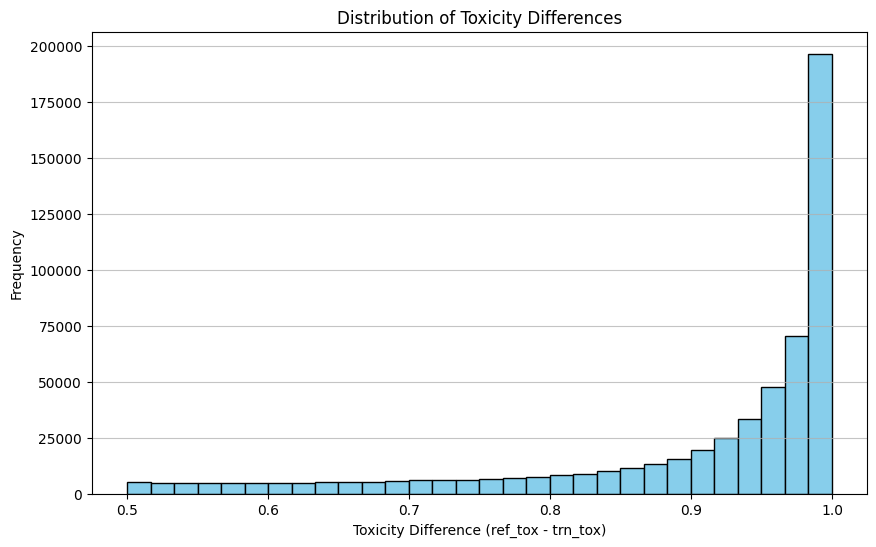

In [40]:
# How to find out "big enough" though?
import matplotlib.pyplot as plt

filtered_data_diff = filtered_data_swapped.copy()
filtered_data_diff['tox_diff'] = (filtered_data_diff['ref_tox'] - filtered_data_diff['trn_tox']).abs()
# Plot the differences between the toxicity levels
plt.figure(figsize=(10, 6))
plt.hist(filtered_data_diff['tox_diff'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Toxicity Differences')
plt.xlabel('Toxicity Difference (ref_tox - trn_tox)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

### I still have no idea, but let's take 0.6 as the value and experiment with it

In [12]:
high_toxicity_threshold = 0.6

# Filter the dataset for high toxicity differences
final_data = filtered_data_diff[filtered_data_diff['tox_diff'] > high_toxicity_threshold].sort_values(by='ref_tox', ascending=True)

# Display the entries with low toxicity differences
final_data

,reference,translation,ref_tox,trn_tox,tox_diff
295354,shite i dont think theyre very happy,i dont think theyre very happy,0.600186,0.000048,0.600138
463665,if you want to understand animals i mean i mea...,if you want to understand game i mean really u...,0.600211,0.000096,0.600115
9913,sonia that smells awful,sonio that is a terrible thing,0.600287,0.000106,0.600180
23368,sam dolans father is out of his mind,sam dolans father checks out,0.600304,0.000047,0.600257
307374,theres a guy out there whos fucking serious,this is one very serious boy we have out there,0.600321,0.000095,0.600226
...,...,...,...,...,...
265344,thats why i sent those idiots to watch you,thats why i sent those human turnips out to wa...,0.999724,0.007180,0.992544
551255,his father would have used a booming voice to ...,his father would have answered with his thunde...,0.999724,0.004599,0.995124
133403,because your idiot husband couldnt just wave m...,because your bozo husband couldnt just wave me...,0.999724,0.013691,0.986033
455358,thats the last time we played poker with some ...,that is the last time i play poker with some h...,0.999726,0.076075,0.923651


### Deciding on the length of the embeddings


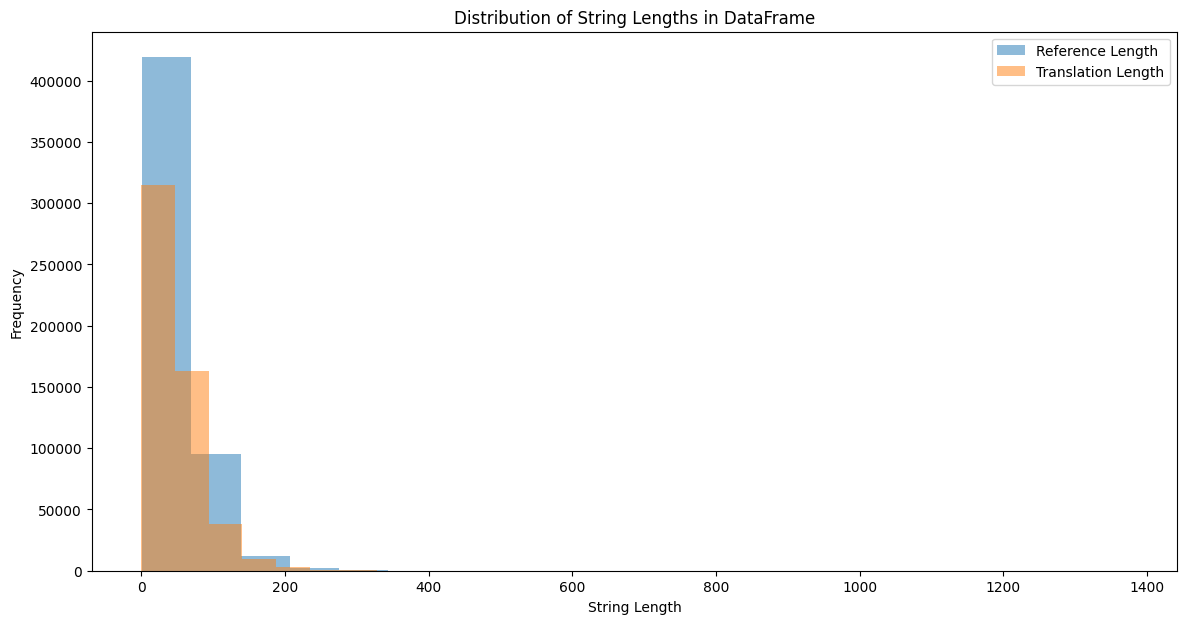

In [19]:
# Let's see the distribution of the length of the strings
import matplotlib.pyplot as plt

# Calculate string lengths for each column
final_data['reference_length'] = final_data['reference'].apply(len)
final_data['translation_length'] = final_data['translation'].apply(len)

# Plotting the distribution of string lengths
plt.figure(figsize=(14, 7))

# Histogram for the 'reference' column
plt.hist(final_data['reference_length'], bins=20, alpha=0.5, label='Reference Length')

# Histogram for the 'translation' column
plt.hist(final_data['translation_length'], bins=20, alpha=0.5, label='Translation Length')

plt.title('Distribution of String Lengths in DataFrame')
plt.xlabel('String Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

In [29]:
# Let's take 256 as the length of the embeddings, and see how much points will be cut off
print(final_data.shape)
data = final_data[(final_data['reference_length'] <= 256) & (final_data['translation_length'] <= 256)]
longest_ref_len = data['reference'].apply(len).max()
longest_tra_len = data['translation'].apply(len).max()
training_data = data.drop(['reference_length', 'translation_length', 'tox_diff', 'ref_tox', 'trn_tox'], axis=1)
print(training_data.shape)

(529324, 7)
(527989, 2)


Just ~2000 samples were dropped, so we will take this value

In [36]:
training_data.to_csv('../data/interim/training_data.csv', index=False)
training_data.isna().sum()

reference      0
translation    0
dtype: int64

In [38]:
dff = pd.read_csv('../data/interim/training_data.csv', dtype={'toxic_column': str, 'nontoxic_column': str})
print(dff.isna().sum())
nan_rows = dff[dff.isna().any(axis=1)]

nan_rows

reference      0
translation    2
dtype: int64


,reference,translation
24184,fool and fracture em,NaN
318453,and sophie tucker will shit i know,NaN


# What?
> 24257 nan <br>
> 319614 nan

In [23]:
print(dff.iloc[24257])
print(training_data.iloc[24257])
print()
print(dff.iloc[319614])
print(training_data.iloc[319614])

reference            you acted like a hamster but
translation    youve behaved like a christian but
Name: 24257, dtype: object
reference            you acted like a hamster but
translation    youve behaved like a christian but
Name: 7619, dtype: object

reference      fucking worse than ever
translation            worse than ever
Name: 319614, dtype: object
reference      fucking worse than ever
translation            worse than ever
Name: 229143, dtype: object


Empty strings!

In [39]:
# Fix
dff.dropna(inplace=True)
print(dff.iloc[24257])
dff.to_csv('../data/interim/training_data.csv', index=False)

reference      but if her mother finds out about this shell g...
translation    but if her mom finds out about that she will t...
Name: 24258, dtype: object


Works now!